# APPROACH 1

## Import & Globals:

In [1]:
import sys
import os
import random as rd

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import StratifiedShuffleSplit
# from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

import tensorflow as tf
from tensorflow import keras


raw_data_folder = os.path.abspath('/home/siedan/programming/masterarbeit/code/analysis/raw_data')

def load_df(name):
    return pd.read_csv(os.path.join(raw_data_folder, name))

scaler = StandardScaler()
df = load_df('adapted_data.csv').drop(['Unnamed: 0'], axis =1)

features_year1 = ['styria_dummy', 'not_styria_dummy', 'germany_dummy',
                  'num_parallel_studies', 'cum_ects_pos_before', 'years_since_matura', 'firstGen',
                  'geschlecht', 'AHS_dummy', 'BHS_dummy', 'ausland_vorbildung_dummy',
                  'sonstige_vorbildung_dummy', 'jus_dummy', 'bwl_dummy',
                  'delayed_dummy', 'ECTS_year', 'active_dummy']

features_years = ['Studienjahr', 'styria_dummy', 'not_styria_dummy', 'germany_dummy',
                  'num_parallel_studies', 'cum_ects_pos_before', 'avgECTS_sem_before', 'ects_year_before',
                  'full_duration_sem_before', 'geschlecht', 'years_since_matura', 'firstGen', 'AHS_dummy',
                  'BHS_dummy', 'ausland_vorbildung_dummy', 'sonstige_vorbildung_dummy',
                  'delayed_dummy', 'jus_dummy', 'bwl_dummy',
                  'ECTS_year', 'active_dummy']



## Algorithms for transition:

### Help Functions:

In [2]:
def active(df_, prediction):
    df = df_.copy(deep = True)
    df.reset_index(drop = True)
    if len(df) == len(prediction):
        new_column = []
        for i in range(len(prediction)):
            if prediction[i] >= 16:
#             a = rd.random()
#             if a > 0.1:
                new_column.append(1)
            else:
                new_column.append(0)
        df.insert(len(df.columns), 'active_predicted', new_column, allow_duplicates = True)
        df.insert(len(df.columns), 'ECTS_predicted', prediction, allow_duplicates = True)
    else:
        print('ERROR')
    return df

    
def ratio(df):
    ratio = 0
    for i in df.index:
        if df.loc[i, 'active_dummy'] == df.loc[i, 'active_predicted']:
            ratio +=1
    ratio = ratio/len(df)
    return ratio


def display_scores(scores):
    print('Scores: ', scores)
    print('Mean: ', scores.mean())
    print('Standard deviation: ', scores.std())


def create_data1(df):
    df = df.query('Studienjahr == 1')[features_year1].dropna().reset_index(drop = True).copy(deep = True)
    split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.1, random_state = 42)
    for train_index, test_index in split.split(df, df['active_dummy']):
        df_train = df.loc[train_index, :]
        df_test = df.loc[test_index, :]
    df_train_copy = df_train.copy(deep = True)
    y_train = list(df_train['ECTS_year'])
    y_test = list(df_test['ECTS_year'])
    df_train = scaler.fit_transform(df_train.drop(['ECTS_year', 'active_dummy'], axis = 1))
    df_test = scaler.fit_transform(df_test.drop(['ECTS_year', 'active_dummy'], axis = 1))
    return df_train, y_train, df_test, y_test, df_train_copy

def create_data2(df):
    df = df.query('Studienjahr > 1')[features_years].dropna().reset_index(drop = True).copy(deep = True)
    split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.1, random_state = 42)
    for train_index, test_index in split.split(df, df['active_dummy']):
        df_train = df.loc[train_index, :]
        df_test = df.loc[test_index, :]
    df_train_copy = df_train.copy(deep = True)
    y_train = list(df_train['ECTS_year'])
    y_test = list(df_test['ECTS_year'])
    df_train = scaler.fit_transform(df_train.drop(['ECTS_year', 'active_dummy'], axis = 1))
    df_test = scaler.fit_transform(df_test.drop(['ECTS_year', 'active_dummy'], axis = 1))
    return df_train, y_train, df_test, y_test, df_train_copy


def training_regression(df_train, y_train, df_train_copy, model): # df_train is already scaled!
    model = sklearn.base.clone(model)
    model.fit(df_train, y_train)
    
    predictions = cross_val_predict(model, df_train, y_train, cv=3)
    rmse = np.sqrt(mean_squared_error(y_train, predictions))
    mae = mean_absolute_error(y_train, predictions)
    R_squared = r2_score(y_train, predictions)
    
    print('RMSE = ' + str(rmse))
    print('MAE = ' + str(mae))
    print('R2_score = ' + str(R_squared))
    print('----------')
    df_new = active(df_train_copy, predictions)
    print('Ratio = ' + str(ratio(df_new)))
    scores = cross_val_score(model, df_train, y_train, scoring = 'neg_mean_squared_error', cv = 5)
    rmse_scores = np.sqrt(-scores)
    display_scores(rmse_scores)
    print('##########')
    
    return model

### Data Generating:

In [3]:
# Year 1 - 2:
df1_train, y1_train, df1_test, y1_test, df1_train_copy = create_data1(df)

# Year 2 -:

df2_train, y2_train, df2_test, y2_test, df2_train_copy = create_data2(df)

### Linear Regression:

In [4]:
lin_reg = LinearRegression()

# Year 1 - 2:

reg1 = training_regression(df1_train, y1_train, df1_train_copy, lin_reg)

# Year 2 -:

reg2 = training_regression(df2_train, y2_train, df2_train_copy, lin_reg)



RMSE = 18.77059116012316
MAE = 15.568643160739695
R2_score = 0.06143971832539552
----------
Ratio = 0.614751552795031
Scores:  [18.56621145 18.69723028 18.77246858 19.1007684  18.70248712]
Mean:  18.767833167684124
Standard deviation:  0.17931734237340144
##########
RMSE = 16.792785050149078
MAE = 13.304248972681252
R2_score = 0.3841822963766356
----------
Ratio = 0.8015368701049209
Scores:  [16.68162667 17.15400082 16.62796605 16.58746386 16.84936219]
Mean:  16.780083917667913
Standard deviation:  0.2071470468154349
##########


### Support Vector Machines:


### Hyperparameters:
- kernel: linear, polynomial, gaussian or sigmoid. Uses the kernel trick to compute additional features.

- gamma: if the model ist underfitting I should increase it. If the model is overfitting I should decrease it.
 
- C: is a parameter which controls the margin violations. Higher more violations, but generalizes better.

- epsilion (only for regression): controls the width of the "street". Similar to C. However, I don't get the difference. 


In [5]:
svm_reg = SVR(kernel = 'rbf', gamma = 10, C = 100, epsilon = 5)

# Year 1 - 2:
svm1 = training_regression(df1_train, y1_train, df1_train_copy, svm_reg)

# Year 2 - :
svm2 = training_regression(df2_train, y2_train, df2_train_copy, svm_reg)


RMSE = 19.89854674184339
MAE = 15.890890266276436
R2_score = -0.05474867822405449
----------
Ratio = 0.595807453416149
Scores:  [19.31515662 19.83359328 19.73776373 20.31628386 19.35934422]
Mean:  19.712428343181685
Standard deviation:  0.36399382930308655
##########
RMSE = 19.490492903716163
MAE = 16.17574093496439
R2_score = 0.17043130189145927
----------
Ratio = 0.6610758090734447
Scores:  [19.52782288 19.26343423 19.33188666 18.74589554 19.26255786]
Mean:  19.22631943389953
Standard deviation:  0.25905467236977164
##########


### Random Forest:


### Hyperparameters:
- n_estimators: number of Decsiontrees.
- max_depths: maximal depth of each tree.
- max_leaf_nodes: controls the depths of the trees.
- criterion: mse or msa. function to measure the quality of the split.
- max_samples: (bootstrap = True) How many samples from df_train are drawn to train each regressor.


In [6]:
forest_reg = RandomForestRegressor(
#             n_estimators = 500, max_depth = 150, max_leaf_nodes = 100, criterion = 'mae',
#             max_samples = 500
        )

forest1 = training_regression(df1_train, y1_train, df1_train_copy, forest_reg)

# Year 2 -:
forest2 = training_regression(df2_train, y2_train, df2_train_copy, forest_reg)



RMSE = 19.438566614408373
MAE = 15.858175866688264
R2_score = -0.006548590666372922
----------
Ratio = 0.6090062111801242
Scores:  [18.9070478  19.23735648 19.27033251 19.6753801  19.04821882]
Mean:  19.227667140504884
Standard deviation:  0.25975356634470487
##########
RMSE = 15.531487866422312
MAE = 11.585475281884428
R2_score = 0.4732156849685838
----------
Ratio = 0.784912073296882
Scores:  [15.82945108 15.41015298 15.48647936 15.16328423 15.3851936 ]
Mean:  15.454912250397143
Standard deviation:  0.2159568485062251
##########


### Artificial Neural Networks:

- epochs: So oft wird ueber alle Trainingsdaten iteriert.
- batch_size: So gross ist ein batch fuer den ein Gradient berechnet wird. (Keine Ahnung wie das mit SGD geht)

In [7]:
def training_ann_regression(df_train, y_train, df_train_copy):
    model = keras.models.Sequential([
        keras.layers.Dense(60, activation = 'relu', input_shape = df_train.shape[1:]),
        keras.layers.Dense(40, activation = 'relu'),
        keras.layers.Dense(20, activation = 'relu'),
        keras.layers.Dense(1, activation = 'relu')
    ])
    model.compile(loss = 'huber', optimizer = 'sgd')
    history = model.fit(df_train, np.array(y_train), epochs = 35, validation_split = 0.1)
    
    predictions = model.predict(df_train)
    rmse = np.sqrt(mean_squared_error(y_train, predictions))
    mae = mean_absolute_error(y_train, predictions)
    R_squared = r2_score(y_train, predictions)
    
    print('RMSE = ' + str(rmse))
    print('MAE = ' + str(mae))
    print('R2_score = ' + str(R_squared))
    print('----------')
    df_new = active(df_train_copy, predictions)
    print('Ratio = ' + str(ratio(df_new)))
    print('##########')
    
    return model, history


Epoch 1/35
182/182 [==============================] - 1s 2ms/step - loss: 16.3272 - val_loss: 15.0597
Epoch 2/35
182/182 [==============================] - 0s 1ms/step - loss: 14.5081 - val_loss: 15.0185
Epoch 3/35
182/182 [==============================] - 0s 1ms/step - loss: 14.4496 - val_loss: 14.7844
Epoch 4/35
182/182 [==============================] - 0s 1ms/step - loss: 14.3915 - val_loss: 14.6499
Epoch 5/35
182/182 [==============================] - 0s 1ms/step - loss: 14.3315 - val_loss: 14.7452
Epoch 6/35
182/182 [==============================] - 0s 1ms/step - loss: 14.3223 - val_loss: 14.6234
Epoch 7/35
182/182 [==============================] - 0s 1ms/step - loss: 14.2912 - val_loss: 14.5823
Epoch 8/35
182/182 [==============================] - 0s 1ms/step - loss: 14.2380 - val_loss: 15.2007
Epoch 9/35
182/182 [==============================] - 0s 1ms/step - loss: 14.2435 - val_loss: 14.7040
Epoch 10/35
182/182 [==============================] - 0s 1ms/step - loss: 14.2259

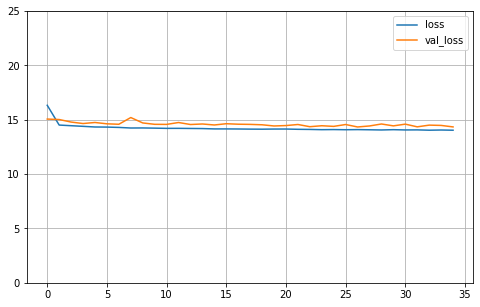

In [8]:
ann1, history1 = training_ann_regression(df1_train, y1_train, df1_train_copy)

pd.DataFrame(history1.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 25)
plt.show()


Epoch 1/35
381/381 [==============================] - 1s 1ms/step - loss: 15.0068 - val_loss: 11.7875
Epoch 2/35
381/381 [==============================] - 0s 1ms/step - loss: 11.6248 - val_loss: 11.1955
Epoch 3/35
381/381 [==============================] - 0s 1ms/step - loss: 11.1071 - val_loss: 11.0603
Epoch 4/35
381/381 [==============================] - 0s 1ms/step - loss: 10.8421 - val_loss: 10.8316
Epoch 5/35
381/381 [==============================] - 1s 1ms/step - loss: 10.6462 - val_loss: 10.6780
Epoch 6/35
381/381 [==============================] - 0s 1ms/step - loss: 10.5687 - val_loss: 10.4739
Epoch 7/35
381/381 [==============================] - 0s 1ms/step - loss: 10.4727 - val_loss: 10.4514
Epoch 8/35
381/381 [==============================] - 0s 1ms/step - loss: 10.4342 - val_loss: 10.4415
Epoch 9/35
381/381 [==============================] - 0s 1ms/step - loss: 10.3846 - val_loss: 10.4651
Epoch 10/35
381/381 [==============================] - 0s 1ms/step - loss: 10.3515

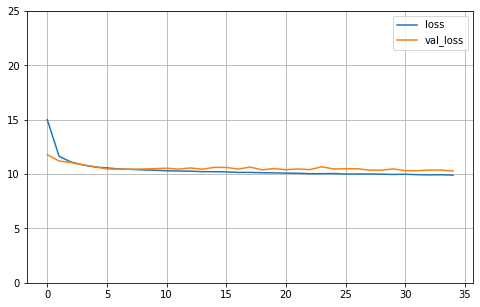

In [9]:
ann2, history2 = training_ann_regression(df2_train, y2_train, df2_train_copy)

pd.DataFrame(history2.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 25)
plt.show()

# Simulation of Model 1:

In [10]:
df_pretty = load_df('df_pretty.csv').drop(['Unnamed: 0'], axis =1)


In [11]:
groups = df_pretty.groupby('matrikel_num')
list_of_students = [] # list von df's, wobei jedes df einen Studenten oder eine Studentin ueber mehrere Jahre hinweg beschreibt.

for i in df_pretty['matrikel_num'].drop_duplicates():
    list_of_students.append(groups.get_group(i))
    


In [12]:
predictors = [svm1, svm2]
features = [features_year1[:-2], features_years[:-2]]

test_student = list_of_students[257]


def update(input_series):
    series = input_series.copy(deep = True)
    series['ects_year_before'] = series['ects_predicted']
    series['cum_ects_pos_before'] += series['ects_predicted']
    if series['Studienjahr'] == 1:
        series['full_duration_sem_before'] = 2
    else:
        series['full_duration_sem_before'] += 2
    series['avgECTS_sem_before'] = series['cum_ects_pos_before']/series['full_duration_sem_before']
    series['Studienjahr'] += 1
    return series

def predict(input_student, predictors, features):
    student = input_student.copy(deep = True)
    if student['Studienjahr'] == 1:
        predictor = predictors[0]
        feature = features[0]
    else:
        predictor = predictors[1]
        feature = features[1]
    
    student['ects_predicted'] = float(predictor.predict(pd.DataFrame(student[feature]).T))
    
    if student['ects_predicted'] >= 16:
        student['active_predicted'] = 1
    else:
        student['active_predicted'] = 0
    return student


def model_student(df, predictors, features):
    n_years = len(df)
    student = df.iloc[0].fillna(0) # Series object # fillna kann Fehler erzeugen!
    list_of_years = [] # initialisiere Liste der Jahre. Erster Eintrag soll dann erstes Jahr mit predicteten ECTS sein.
    
    for i in range(n_years):
        new_student = predict(student, predictors, features).copy(deep = True)
        
        list_of_years.append(new_student)
        
        student = update(list_of_years[-1])
        
    new_df = list_of_years[0].to_frame().T
    
    for year in list_of_years[1:]:
        new_df = new_df.append(year.to_frame().T)
    
    return new_df.reset_index(drop = True)
   
    
test = model_student(test_student, predictors, features)
test_student = test_student.append(test)[['ects_year_before', 'ects_predicted', 'ECTS_year', 'SWS_year',
                           'active_predicted', 'active_dummy', 'avgECTS_sem_before', 'full_duration_sem_before',
                           'cum_ects_pos_before','subject']]
test_student


    

,ects_year_before,ects_predicted,ECTS_year,SWS_year,active_predicted,active_dummy,avgECTS_sem_before,full_duration_sem_before,cum_ects_pos_before,subject
1085,NaN,NaN,65.0,36.0,NaN,1,0.0,0.0,0.0,Padagogik
1086,65.0,NaN,55.0,24.0,NaN,1,32.5,2.0,65.0,Padagogik
1087,55.0,NaN,32.0,16.0,NaN,1,30.0,4.0,120.0,Padagogik
1088,32.0,NaN,3.0,2.0,NaN,1,30.4,5.0,152.0,Padagogik
0,0,15.422166,65.0,36.0,0,1,0.0,0.0,0.0,Padagogik
1,15.422166,23.015109,65.0,36.0,1,1,7.711083,2,15.422166,Padagogik
2,23.015109,23.015109,65.0,36.0,1,1,9.609319,4,38.437275,Padagogik
3,23.015109,23.015109,65.0,36.0,1,1,10.242064,6,61.452384,Padagogik


In [13]:
test_data = list_of_students[:500]
count = 0
for student in test_data:
    prediction = model_student(student, predictors, features)
    student = student.append(prediction).reset_index(drop = True)
    if student['active_dummy'][3] == student['active_predicted'][7]:
        
        count += 1
count

356

Es funktioniert leider nicht, dass man rein nur mit predicteten ECTS über Jahre hinweg weitervorhersagt, ob ein
Student oder eine Studentin in ca. 3 Jahren noch prüfungsaktiv ist oder nicht. Es hängt nämlich auch von Abschluss
oder Abbruch ab. Weiters sind die Fehlerfortpflanzungen zu groß.